In [1]:
!pip install osqp

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for osqp from https://files.pythonhosted.org/packages/3a/c4/d47ccafc3e149c1b9b860c63fbdbaa18dfc06784593cd221c5896be9945c/osqp-1.0.5-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/309.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/309.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/309.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/309.7 kB ? eta -:--:--
   --- ----------------------------------- 30.7/309.7 kB 187.9 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/309.7 kB 164.3 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/309.7 kB 234.9 kB/s eta 0:00:02
   ------------- ------------------------ 112.6/309.7 kB 364.4 kB/s eta 0:00:01
   -------------------- ----------------- 163.8/309.7 kB 492.3 kB/s eta 0:00:01
   ------------------------- ----


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np

# Try importing solvers in priority order
try:
    import osqp
    from scipy import sparse
    QP_BACKEND = 'osqp'
except Exception:
    try:
        import cvxopt
        from cvxopt import matrix, solvers
        QP_BACKEND = 'cvxopt'
        solvers.options['show_progress'] = False
    except Exception:
        from scipy.optimize import minimize
        QP_BACKEND = 'slsqp'

def solve_simple_qp(H, c, Aeq=None, beq=None, lb=None, verbose=False):
    """
    Solve: min 0.5 x^T H x + c^T x
           s.t. Aeq x = beq  (optional)
                lb <= x (lb elementwise, use -inf for unbounded)
    Returns x, success_flag
    Backend: OSQP -> cvxopt -> SLSQP
    H : (n,n) symmetric positive semidef ndarray
    c : (n,) ndarray
    Aeq: (m,n) ndarray or None
    beq: (m,) ndarray or None
    lb : (n,) ndarray or None (lower bounds); if None assume 0 lower bound
    """
    n = H.shape[0]
    if lb is None:
        lb = np.zeros(n)

    if QP_BACKEND == 'osqp':
        # OSQP requires P (H) as sparse csc, and constraints in form l <= Ax <= u
        P = sparse.csc_matrix(H)
        q = c.astype(float)
        # Build A, l, u
        rows = []
        data = []
        cols = []
        A_blocks = []
        l_list = []
        u_list = []
        # equality constraints
        if Aeq is not None:
            Aeq = np.atleast_2d(Aeq).astype(float)
            m = Aeq.shape[0]
            A = sparse.csc_matrix(Aeq)
            l = beq.astype(float)
            u = beq.astype(float)
            # Now bounds x >= lb  =>  I x >= lb  -> implemented by adding rows
            if lb is not None:
                I = sparse.eye(n).tocsc()
                A = sparse.vstack([A, I]).tocsc()
                l = np.concatenate([l, lb.astype(float)])
                u = np.concatenate([u, np.full(n, np.inf)])
        else:
            # only bounds
            A = sparse.eye(n).tocsc()
            l = lb.astype(float)
            u = np.full(n, np.inf)
        prob = osqp.OSQP()
        prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=verbose)
        res = prob.solve()
        x = res.x
        success = (res.info.status == 'solved')

        return x, success

    elif QP_BACKEND == 'cvxopt':
        # cvxopt expects matrices
        P = matrix(H)
        q = matrix(c)
        # inequality constraints Gx <= h ; we have x >= lb -> -I x <= -lb
        G_list = []
        h_list = []
        I = matrix(-np.eye(n))
        h_list.append(matrix(-lb))
        G = I
        h = h_list[0]
        if Aeq is not None:
            A = matrix(Aeq.astype(float))
            b = matrix(beq.astype(float))
            sol = solvers.qp(P, q, G, h, A, b)
        else:
            sol = solvers.qp(P, q, G, h)
        x = np.array(sol['x']).ravel()
        success = (sol['status'] == 'optimal')
        return x, success

    else:  # SLSQP fallback via scipy.minimize
        # objective and gradient
        def fun(x):
            return 0.5 * float(x @ (H @ x)) + float(c @ x)
        def jac(x):
            return H @ x + c
        cons = []
        if Aeq is not None:
            Aeq = np.atleast_2d(Aeq).astype(float)
            beq = np.asarray(beq).astype(float)
            def eqfun(x, Aeq=Aeq, beq=beq): return Aeq.dot(x) - beq
            def eqjac(x, Aeq=Aeq): return Aeq
            cons.append({'type': 'eq', 'fun': lambda x: eqfun(x), 'jac': lambda x: eqjac(x)})
        bounds = [(lb_i, None) for lb_i in lb]
        x0 = np.maximum(1.0/n, lb)  # feasible initial guess (sum not enforced)
        # If equality exists, prepare a projected initial guess that satisfies Aeq x = beq
        if Aeq is not None:
            # simple least squares to satisfy Aeq x = beq (ignore bounds for initial)
            try:
                x0 = np.linalg.lstsq(Aeq, beq, rcond=None)[0]
                x0 = np.maximum(x0, lb)
            except Exception:
                x0 = np.maximum(np.ones(n) / n, lb)
        res = minimize(fun, x0, jac=jac, constraints=cons, bounds=bounds, method='SLSQP',
                       options={'ftol':1e-12, 'maxiter':500, 'disp': False})
        return res.x, res.success


######## Active-set projection algorithm using the dedicated QP solver ########

def project_onto_convex_hull_with_qp(S, P, tol=1e-12, max_iters=1000):
    """
    Active-set projection onto conv(S) using a fast QP solver for small QPs.
    S : (n, d) ndarray
    P : (d,) ndarray
    Returns: x_proj (d,), full_weights (n,), active_indices (list)
    """
    S = np.asarray(S, dtype=float)
    P = np.asarray(P, dtype=float).ravel()
    n, d = S.shape
    if P.shape[0] != d:
        raise ValueError("Dimension mismatch")

    # Start at nearest vertex
    dists = np.sum((S - P)**2, axis=1)
    k = int(np.argmin(dists))
    A = [k]           # active indices (global indices)
    w = np.array([1.0])   # weights on active set
    x = S[k].copy()

    it = 0
    while it < max_iters:
        it += 1
        # compute KKT search direction test values Delta_i = (x-P) dot (s_i - x)
        xp = x - P
        # Efficient computation: (x-P).dot(s_i) - (x-P).dot(x)
        dot_si = S.dot(xp)           # shape (n,)
        const = xp.dot(x)            # scalar
        Deltas = dot_si - const
        j = int(np.argmin(Deltas))
        if Deltas[j] >= -tol:
            # optimal
            break

        # add candidate vertex j
        if j not in A:
            A.append(j)
        # solve QP on active set A to get best weights
        while True:
            VA = S[A].T   # (d, m)
            m = VA.shape[1]
            # Form H and c for objective 0.5 w^T H w + c^T w  where VA @ w = x_candidate
            # Note: objective ||VA w - P||^2 = w^T (VA^T VA) w - 2 (VA^T P)^T w + const
            H = 2.0 * (VA.T @ VA)     # m x m
            c = -2.0 * (VA.T @ P)     # m
            # equality: sum w = 1
            Aeq = np.ones((1, m))
            beq = np.array([1.0])
            lb = np.zeros(m)
            w_candidate, success = solve_simple_qp(H, c, Aeq=Aeq, beq=beq, lb=lb)
            if not success:
                # fallback: clip and renormalize simple least-squares
                w_candidate = np.maximum(w_candidate, 0.0)
                ssum = w_candidate.sum()
                if ssum <= 0:
                    w_candidate = np.ones(m) / m
                else:
                    w_candidate /= ssum

            # If candidate has all nonnegative weights (within tol) accept
            if np.all(w_candidate >= -tol):
                w_candidate = np.maximum(w_candidate, 0.0)
                ssum = w_candidate.sum()
                if ssum <= 0:
                    w_candidate = np.ones_like(w_candidate) / len(w_candidate)
                else:
                    w_candidate /= ssum
                w = w_candidate
                x = VA @ w
                break

            # Otherwise need a drop step: move from current w_old_on_A to w_candidate
            # Build w_old_on_A: represent current x as weights on A (solve small QP with x as target)
            # That QP is same as above but target is x -> minimize ||VA w - x||^2 s.t. sum w =1, w>=0
            H_tmp = 2.0 * (VA.T @ VA)
            c_tmp = -2.0 * (VA.T @ x)
            w_old_on_A, succ_old = solve_simple_qp(H_tmp, c_tmp, Aeq=np.ones((1, m)),
                                                   beq=np.array([1.0]), lb=np.zeros(m))
            # compute t* = min { w_old_i / (w_old_i - w_candidate_i) : w_candidate_i < 0 }
            ts = []
            for idx in range(m):
                if w_candidate[idx] < -tol:
                    denom = (w_old_on_A[idx] - w_candidate[idx])
                    if denom > 0:
                        ts.append(w_old_on_A[idx] / denom)
            if len(ts) == 0:
                # numerical fallback: remove indices with negative candidate
                keep = [i for i in range(m) if w_candidate[i] >= -tol]
                A = [A[i] for i in keep]
                if len(A) == 0:
                    # fallback to nearest vertex
                    dists = np.sum((S - P)**2, axis=1)
                    k = int(np.argmin(dists))
                    A = [k]; w = np.array([1.0]); x = S[k].copy()
                    break
                continue
            t_star = min(ts)
            t_star = np.clip(t_star, 0.0, 1.0)
            w_interp = w_old_on_A + t_star * (w_candidate - w_old_on_A)
            # drop zeros
            keep_idx_local = [i for i, val in enumerate(w_interp) if val > 1e-14]
            A = [A[i] for i in keep_idx_local]
            if len(A) == 0:
                dists = np.sum((S - P)**2, axis=1)
                k = int(np.argmin(dists))
                A = [k]; w = np.array([1.0]); x = S[k].copy()
                break
            # loop and re-solve on reduced A

    # compose full weight vector
    full_w = np.zeros(n)
    for local_idx, global_idx in enumerate(A):
        full_w[global_idx] = w[local_idx]
    x_proj = S.T.dot(full_w) if n > 0 else np.zeros_like(P)
    return x_proj, full_w, A

###############################
# small demo: 2D triangle plot #
###############################
def plot_triangle_projection():
    import matplotlib.pyplot as plt
    A = np.array([-1.0, 0.0])
    B = np.array([ 1.0, 0.0])
    T = np.array([ 0.0, 0.1])   # top vertex (closest to P)
    S = np.vstack([A, B, T])
    P = np.array([0.0, -1.0])

    xproj, w, Aidx = project_onto_convex_hull_with_qp(S, P)
    print("Projected point:", xproj)
    print("Weights:", w)
    print("Active indices:", Aidx)

    plt.figure(figsize=(5,5))
    # triangle
    tri = np.vstack([S, S[0]])
    plt.plot(tri[:,0], tri[:,1], '-k')
    plt.scatter(S[:,0], S[:,1], c='C0', s=60, label='S vertices')
    plt.scatter(P[0], P[1], c='C1', s=80, label='P')
    plt.scatter(xproj[0], xproj[1], c='C2', s=80, label='Projection')
    # draw foot from P to projection
    plt.plot([P[0], xproj[0]], [P[1], xproj[1]], '--', color='gray')
    plt.gca().set_aspect('equal', 'box')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: run plot demo (uncomment to run)
# plot_triangle_projection()


Projected point: [2.22044605e-16 0.00000000e+00]
Weights: [0.5 0.5 0. ]
Active vertices (indices): [0, 1]
Active vertices (coordinates): [[-1.  0.]
 [ 1.  0.]]


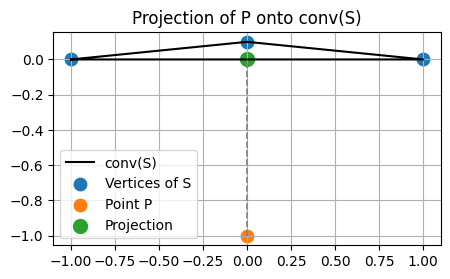

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the triangle (convex hull vertices)
A = np.array([-1.0, 0.0])
B = np.array([ 1.0, 0.0])
T = np.array([ 0.0, 0.1])  # top vertex (closest to P)
S = np.vstack([A, B, T])

# Define the query point P (outside the hull)
P = np.array([0.0, -1.0])

# Run the projection
x_proj, w, active = project_onto_convex_hull_with_qp(S, P)

print("Projected point:", x_proj)
print("Weights:", np.round(w, 4))
print("Active vertices (indices):", active)
print("Active vertices (coordinates):", S[active])

# --- Visualization ---
plt.figure(figsize=(5, 5))
# Draw convex hull
hull = np.vstack([S, S[0]])
plt.plot(hull[:,0], hull[:,1], 'k-', lw=1.5, label='conv(S)')
# Draw points
plt.scatter(S[:,0], S[:,1], c='C0', s=80, label='Vertices of S')
plt.scatter(P[0], P[1], c='C1', s=80, label='Point P')
plt.scatter(x_proj[0], x_proj[1], c='C2', s=100, label='Projection')
# Connect P to projection
plt.plot([P[0], x_proj[0]], [P[1], x_proj[1]], '--', color='gray', lw=1.2)
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.grid(True)
plt.title("Projection of P onto conv(S)")
plt.show()


Projected point: [0.9085 0.3415]
Weights: [0.3169 0.6831 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.    ]
Active vertices: [1, 0]


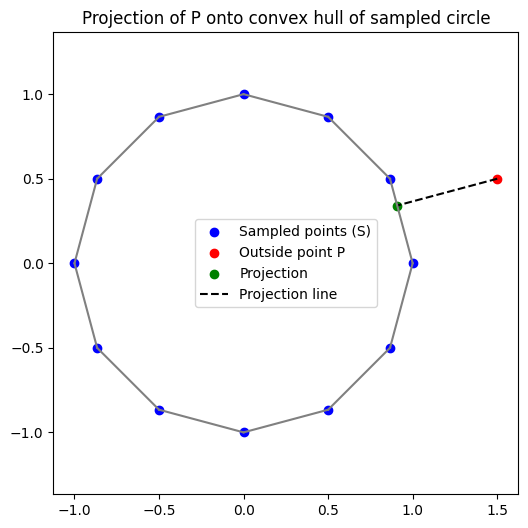

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Step 1: sample points on a circle ----
n_points = 12
theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
r = 1.0
S = np.stack([r * np.cos(theta), r * np.sin(theta)], axis=1)

# ---- Step 2: define an outside point P ----
P = np.array([1.5, 0.5])  # clearly outside the unit circle

# ---- Step 3: call the projection function ----
x_proj, w, active = project_onto_convex_hull_with_qp(S, P)

print("Projected point:", np.round(x_proj, 4))
print("Weights:", np.round(w, 4))
print("Active vertices:", active)

# ---- Step 4: visualize ----
plt.figure(figsize=(6,6))
plt.scatter(S[:,0], S[:,1], color='blue', label='Sampled points (S)')
plt.scatter(P[0], P[1], color='red', label='Outside point P')
plt.scatter(x_proj[0], x_proj[1], color='green', label='Projection')
plt.plot([P[0], x_proj[0]], [P[1], x_proj[1]], 'k--', label='Projection line')

# draw convex hull edges (optional)
from scipy.spatial import ConvexHull
hull = ConvexHull(S)
for simplex in hull.simplices:
    plt.plot(S[simplex, 0], S[simplex, 1], 'gray')

plt.axis('equal')
plt.legend()
plt.title("Projection of P onto convex hull of sampled circle")
plt.show()



===== VERTICES S =====
[[ 1.00000000e+00  0.00000000e+00]
 [ 8.66025404e-01  5.00000000e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 6.12323400e-17  1.00000000e+00]
 [-5.00000000e-01  8.66025404e-01]
 [-8.66025404e-01  5.00000000e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-8.66025404e-01 -5.00000000e-01]
 [-5.00000000e-01 -8.66025404e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 5.00000000e-01 -8.66025404e-01]
 [ 8.66025404e-01 -5.00000000e-01]]

===== YOUR ESTIMATE =====
Projected point (algorithm): [0.908488 0.341529]
Weights: [0.316943 0.683057 0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.      ]
Active vertices: [1, 0]

===== TRUE PROJECTION =====
Projected point (true): [0.908494 0.341506]
Weights: [0.316987 0.683013 0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.      ]

===== COMPARISON METRICS =====
||x_alg - x_true|| = 2.3182658982194712e-05
||w_alg - w_true||_1 = 8.957091613214704e-05


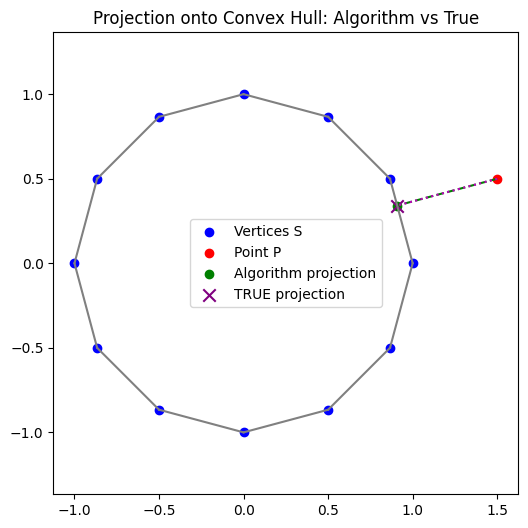

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

# -------------------------------------------------------------
# Helper: Solve the true projection using constrained minimization
# -------------------------------------------------------------
def true_projection_onto_convex_hull(S, P):
    """
    Solve:  minimize || S w - P ||^2
            subject to w_i >= 0, sum_i w_i = 1
    """
    m = S.shape[0]  # number of vertices

    # objective
    def obj(w):
        x = S.T @ w   # linear combination
        return np.sum((x - P)**2)

    # gradient (optional but improves speed)
    def grad(w):
        x = S.T @ w
        return 2 * S @ (x - P)

    # constraints
    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
    ]
    bounds = [(0, None) for _ in range(m)]

    # initial guess: uniform weights
    w0 = np.ones(m) / m

    result = minimize(obj, w0, jac=grad, bounds=bounds, constraints=cons)

    w_opt = result.x
    x_opt = S.T @ w_opt
    return x_opt, w_opt


# -------------------------------------------------------------
# Step 1: sample points on a circle
# -------------------------------------------------------------
n_points = 12
theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
r = 1.0
S = np.stack([r * np.cos(theta), r * np.sin(theta)], axis=1)

# -------------------------------------------------------------
# Step 2: define an outside point
# -------------------------------------------------------------
P = np.array([1.5, 0.5])

# -------------------------------------------------------------
# Step 3: run your algorithm's projection
# -------------------------------------------------------------
x_proj, w_proj, active = project_onto_convex_hull_with_qp(S, P)

# -------------------------------------------------------------
# Step 4: compute the TRUE projection
# -------------------------------------------------------------
x_true, w_true = true_projection_onto_convex_hull(S, P)

# -------------------------------------------------------------
# Print results
# -------------------------------------------------------------
print("\n===== VERTICES S =====")
print(S)

print("\n===== YOUR ESTIMATE =====")
print("Projected point (algorithm):", np.round(x_proj, 6))
print("Weights:", np.round(w_proj, 6))
print("Active vertices:", active)

print("\n===== TRUE PROJECTION =====")
print("Projected point (true):", np.round(x_true, 6))
print("Weights:", np.round(w_true, 6))

print("\n===== COMPARISON METRICS =====")
print("||x_alg - x_true|| =", np.linalg.norm(x_proj - x_true))
print("||w_alg - w_true||_1 =", np.sum(np.abs(w_proj - w_true)))


# -------------------------------------------------------------
# Visualization
# -------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(S[:,0], S[:,1], color='blue', label='Vertices S')
plt.scatter(P[0], P[1], color='red', label='Point P')
plt.scatter(x_proj[0], x_proj[1], color='green', label='Algorithm projection')
plt.scatter(x_true[0], x_true[1], color='purple', marker='x', s=80, label='TRUE projection')

plt.plot([P[0], x_proj[0]], [P[1], x_proj[1]], 'g--')
plt.plot([P[0], x_true[0]], [P[1], x_true[1]], 'm:')

# draw convex hull
hull = ConvexHull(S)
for simplex in hull.simplices:
    plt.plot(S[simplex, 0], S[simplex, 1], 'gray')

plt.axis('equal')
plt.legend()
plt.title("Projection onto Convex Hull: Algorithm vs True")
plt.show()


Projected point: [0.7058 0.1021 0.0884]
Weights: [0.    0.429 0.    0.    0.    0.    0.    0.571 0.    0.    0.    0.   ]
Active vertices: [7, 1]


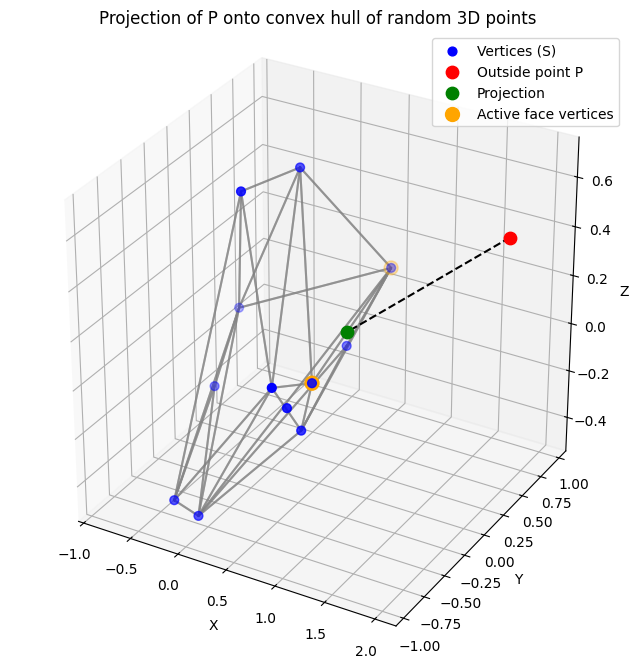

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

# ---- Step 1: generate non-coplanar 3D points ----
np.random.seed(7)
S = np.random.uniform(-1, 1, size=(12, 3))  # 12 random 3D points

# ---- Step 2: define a point P outside the convex hull ----
P = np.array([2.0, 0.5, 0.5])  # well outside on one side

# ---- Step 3: run the projection function ----
x_proj, w, active = project_onto_convex_hull_with_qp(S, P)

print("Projected point:", np.round(x_proj, 4))
print("Weights:", np.round(w, 4))
print("Active vertices:", active)

# ---- Step 4: visualize the polyhedron, P, and projection ----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# convex hull
hull = ConvexHull(S)
for simplex in hull.simplices:
    tri = np.append(simplex, simplex[0])  # close the triangle
    ax.plot(S[tri, 0], S[tri, 1], S[tri, 2], color='gray', alpha=0.6)

# points and projection
ax.scatter(S[:, 0], S[:, 1], S[:, 2], color='blue', s=40, label='Vertices (S)')
ax.scatter(*P, color='red', s=80, label='Outside point P')
ax.scatter(*x_proj, color='green', s=80, label='Projection')
ax.plot([P[0], x_proj[0]], [P[1], x_proj[1]], [P[2], x_proj[2]], 'k--')

# highlight the active vertices (those defining the face of projection)
ax.scatter(S[active, 0], S[active, 1], S[active, 2], color='orange', s=100, label='Active face vertices')

# formatting
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title("Projection of P onto convex hull of random 3D points")
plt.show()


In [12]:
import numpy as np

def verify_projection_onto_convex_hull(S, P, x_hat, w_hat, tol=None, verbose=True):
    """
    Verify that x_hat is the Euclidean projection of P onto conv(S) with barycentric weights w_hat.
    S: (n, d) array (rows are vertices s_i)
    P: (d,) array
    x_hat: (d,) reported projection
    w_hat: (n,) reported weights (sums to 1, >=0)
    Returns: dict with diagnostic values and pass/fail booleans
    """
    S = np.asarray(S, dtype=float)
    P = np.asarray(P, dtype=float).ravel()
    x_hat = np.asarray(x_hat, dtype=float).ravel()
    w_hat = np.asarray(w_hat, dtype=float).ravel()
    n, d = S.shape

    # default tolerance scaled to problem
    # scale = max(1.0, np.linalg.norm(P), np.max(np.linalg.norm(S, axis=1)))
    # if tol is None:
    #     tol = 1e-9 * scale

    scale = max(1.0, np.linalg.norm(P), np.max(np.linalg.norm(S, axis=1)))
    tol = 1e-7 * scale   # less strict than 1e-9*scale


    # 1) feasibility: nonnegativity and sum-to-one
    min_w = np.min(w_hat)
    sum_w = np.sum(w_hat)
    feasible_nonneg = min_w >= -tol
    feasible_sum = abs(sum_w - 1.0) <= tol

    # 2) reconstruction
    x_recon = (w_hat.reshape(-1,1) * S).sum(axis=0)  # sum_i w_i s_i
    recon_err = np.linalg.norm(x_hat - x_recon)

    # 3) KKT checks for all vertices
    diff = P - x_hat     # vector
    s_minus_x = S - x_hat[np.newaxis, :]  # (n,d)
    g = s_minus_x.dot(diff)   # g_j = (s_j - x_hat)·(P - x_hat) = (P-x_hat)·(s_j - x_hat)
    # We expect g_j <= tol for all j
    violations = np.where(g > tol)[0]
    kkt_all_ok = len(violations) == 0

    # 4) Active set checks: indices with significant weight
    active_idx = np.where(w_hat > tol)[0].tolist()
    # For active ones, g should be near 0 (|g| <= tol)
    active_g = g[active_idx] if len(active_idx) > 0 else np.array([])
    active_equal_ok = np.all(np.abs(active_g) <= max(tol, 1e-12))

    # 5) orthogonality to affine hull of active vertices
    affine_ok = True
    orth_res_norm = None
    if len(active_idx) >= 2:
        a0 = active_idx[0]
        M = (S[active_idx] - S[a0])[:, 1:].T if False else (S[active_idx] - S[a0]).T
        # We want M^T (P - x_hat) approx 0, but M may have dependent columns; use norm of projection
        orth_res = M.T.dot(diff)
        orth_res_norm = np.linalg.norm(orth_res)
        affine_ok = orth_res_norm <= max(tol, 1e-9*scale)
    elif len(active_idx) == 1:
        # active face is a vertex: check diff is collinear with (x_hat - that vertex) (trivial)
        orth_res_norm = 0.0
        affine_ok = True

    results = {
        'tol': tol,
        'feasible_nonneg': feasible_nonneg,
        'feasible_sum': feasible_sum,
        'min_weight': float(min_w),
        'sum_weights': float(sum_w),
        'reconstruction_error': float(recon_err),
        'kkt_all_ok': bool(kkt_all_ok),
        'kkt_violation_indices': violations.tolist(),
        'g_values': g,  # array
        'active_indices': active_idx,
        'active_g_values': active_g,
        'active_equal_ok': bool(active_equal_ok),
        'affine_orthogonality_ok': bool(affine_ok),
        'affine_orthogonality_norm': float(orth_res_norm) if orth_res_norm is not None else None
    }

    if verbose:
        print("TOL:", tol)
        print("Weights: min={}, sum={}".format(results['min_weight'], results['sum_weights']))
        print("Feasible (nonneg)?", results['feasible_nonneg'])
        print("Feasible (sum=1)?", results['feasible_sum'])
        print("Reconstruction error ||x_hat - sum w_i s_i|| =", results['reconstruction_error'])
        print("KKT (g_j = (P-x_hat)·(s_j-x_hat)) max:", float(np.max(g)), "min:", float(np.min(g)))
        print("KKT all satisfied (g_j <= tol)?", results['kkt_all_ok'])
        if not results['kkt_all_ok']:
            print(" KKT violation indices:", results['kkt_violation_indices'])
        print("Active indices (w_i > tol):", results['active_indices'])
        print("Active g-values (should be ~0):", results['active_g_values'])
        print("Active equality OK?:", results['active_equal_ok'])
        print("Affine orthogonality norm (should be small):", results['affine_orthogonality_norm'])

    return results

# -------------------------
# Example usage (fill with your actual S, P, x_proj, w_proj):
# S: n x d array
# P: d vector
# x_proj: reported projection
# w_proj: reported weights vector (length n)
# -------------------------
# results = verify_projection_onto_convex_hull(S, P, x_proj, w_proj)
# print(results)


In [13]:

results = verify_projection_onto_convex_hull(S, P, x_proj, w)
print(results)

TOL: 2.1213203435596422e-07
Weights: min=0.0, sum=1.0
Feasible (nonneg)? True
Feasible (sum=1)? True
Reconstruction error ||x_hat - sum w_i s_i|| = 0.0
KKT (g_j = (P-x_hat)·(s_j-x_hat)) max: 2.5208002731236776e-05 min: -1.9151069935361595
KKT all satisfied (g_j <= tol)? False
 KKT violation indices: [1]
Active indices (w_i > tol): [1, 7]
Active g-values (should be ~0): [ 2.52080027e-05 -1.89391154e-05]
Active equality OK?: False
Affine orthogonality norm (should be small): 4.4147118150175207e-05
{'tol': np.float64(2.1213203435596422e-07), 'feasible_nonneg': np.True_, 'feasible_sum': np.True_, 'min_weight': 0.0, 'sum_weights': 1.0, 'reconstruction_error': 0.0, 'kkt_all_ok': False, 'kkt_violation_indices': [1], 'g_values': array([-1.91510699e+00,  2.52080027e-05, -1.51871627e+00, -5.98099446e-01,
       -1.81843661e+00, -1.97733553e-01, -1.69598364e-01, -1.89391154e-05,
       -2.04085945e-01, -2.34335473e-01, -1.86683361e+00, -8.77497771e-01]), 'active_indices': [1, 7], 'active_g_values